# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

# Make the interactive backend as PDF
matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)

plt.style.use("acmcompat.mplstyle")


def figsize(x, y, two_column=False):
    """Make a figure size with respect to a given width.

    Example:
    --------
    >>> mk_figsize(1, 1)
    (3.3374, 3.3374)
    >>> mk_figsize(1, 2)
    (3.3374, 6.6748)
    >>> mk_figsize(1, 1/3, two_column=True)
    (7.00697, 2.2258)
    """
    columnwidth = 3.3374
    textwidth = 7.00697

    w = textwidth if two_column else columnwidth
    return w * x, w * y


SAVEDIR = "/Users/leo/Workspace/imta/assessment-paper/src/figures/"

## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ4**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks? (OPTIONAL)


## RQ5: Are backdoor attacks realistic in IDS context?

Note that this does not refer to the backdoor attacks as often defined in ML, but more as backdoors applied to NIDS, where the attacker makes it so that the IDS does not detect a specific attack or attack pattern.

## Test methodology

- focus on one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)
- focus on targeted attacks (test all targets)
- look especially at the attack success rate (see def in Trust-FIDS)

**Note**: some results must be gathered from other runs (*eg.*, class "dos" has been removed here since it's already available in "attacks/").

In [3]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("backdoor/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"3-7, 7-3, 10-0, 5-5, 9-1"
epochs,100_10x10
scenario,"continuous-60, continuous-100, continuous-30"
target,"ddos, dos, bot, bruteforce, injection, infiltration"
batch_size,512
partitioner,iid
seed,"6567, 421, 2187, 327, 1313, 1977, 3263827, 5555, 501, 1138"


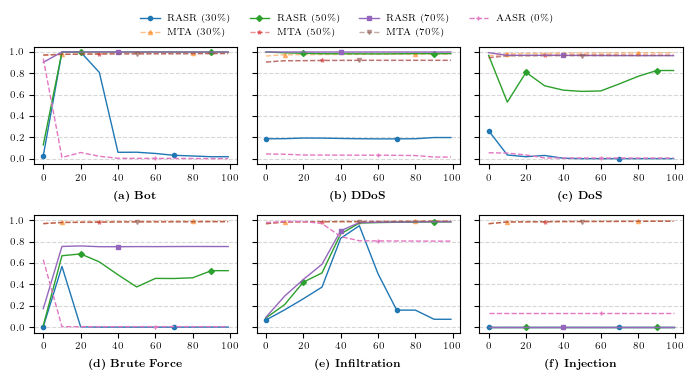

In [4]:
import itertools
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from eiffel.analysis.metrics import load_asr, load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib.axes import Axes

labels = {
    "Bot": "bot",
    "DDoS": "ddos",
    "DoS": "dos",
    "Brute Force": "bruteforce",
    "Infilteration": "infiltration",
    "injection": "injection",
}

fig, axs = plt.subplots(
    2, 3, figsize=figsize(1, 0.5, two_column=True), sharey=True, tight_layout=True
)

for i, label in enumerate(labels):
    ax: Axes = axs[i // 3, i % 3]

    searchfn = partial(
        search_results,
        "backdoor/results/",
        target=labels[label],
        scenario="continuous-100",
    )
    missfn = partial(
        load_metric,
        dotpath=f"{label}.missrate",
        attr="distributed",
        with_malicious=False,
    )
    asrfn = partial(load_asr, target=[label])
    refs = [Plotable(m, asrfn(m)) for m in searchfn(distribution="10-0")]

    for dist in ("7-3", "5-5", "3-7"):
        attack_paths = searchfn(distribution=dist)
        assert len(attack_paths) == 10

        asrs = [
            Plotable(p, asrfn(p, reference=r.values))
            for p, r in zip(attack_paths, refs)
        ]
        asrs = scale(asrs, 100)
        ax.plot(
            np.mean([a.values for a in asrs], axis=0),
            label=rf"RASR ({dist.split('-')[1]}0\%)",
            linestyle="-",
        )

        accs = [
            Plotable(m, load_metric(m, dotpath="global.accuracy")) for m in attack_paths
        ]
        accs = scale(accs, 100)
        ax.plot(
            np.mean([a.values for a in accs], axis=0),
            label=rf"MTA ({dist.split('-')[1]}0\%)",
            linestyle="--",
            alpha=0.5,
        )

        # missrates = [Plotable(m, missfn(m)) for m in attack_paths]
        # missrates = scale(missrates, 100)
        # ax.plot(
        #     np.mean([m.values for m in missrates], axis=0),
        #     label="miss rate",
        #     markevery=(10, 30),
        #     linestyle="-.",
        #     marker="x",
        # )

    refs = scale(refs, 100)
    ax.plot(
        np.mean([r.values for r in refs], axis=0),
        label=r"AASR (0\%)",
        linestyle="--",
    )

    ax.set_title(
        {
            "Bot": "Bot",
            "DDoS": "DDoS",
            "DoS": "DoS",
            "Brute Force": "Brute Force",
            "Infilteration": "Infiltration",
            "injection": "Injection",
        }[label]
    )


abc = "abcdefghijklmnopqrstuvwxyz"
for i, ax in enumerate(axs.ravel()):
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_title(r"\textbf{" f"({abc[i]}) {ax.get_title()}" r"}")
    for line, m, e in zip(ax.lines, itertools.cycle("o^D*sv+x"), range(len(ax.lines))):
        line.set_marker(m)
        line.set_markevery((e * 10, len(ax.lines) * 10))


lgd = fig.legend(
    *axs[0, 0].get_legend_handles_labels(),
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.08),
)

fig.savefig(SAVEDIR + "backdoors.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")